# LIVRABLE 1 - Classification binaire (Projet LEYENDA)

# Objectif : Distinguer les photos naturelles (couleur ou noir et blanc) des autres types d'images (peintures, textes, dessins, schémas...)

CHANGER EN PNG, RESIZE
MODELE RGB
MODELE NB
RECONNAITRE PHOTO PEINTURE


In [2]:
# Importations générales
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow.keras'

In [3]:
# =======================
# Partie 2 : Organisation initiale des dossiers
# =======================

# Chemins des dossiers
source_dir = "../../Projet/Datasets/Datasets Livrable 1"
working_dir = "./images_work"

# Auto-détection des catégories présentes dans source_dir
categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

# Création du dossier de travail et copie des images originales
os.makedirs(working_dir, exist_ok=True)

for category in categories:
    src_path = os.path.join(source_dir, category)
    dst_path = os.path.join(working_dir, category)

    if not os.path.exists(dst_path):
        shutil.copytree(src_path, dst_path)
        print(f"[COPIED] Catégorie : {category}")
    else:
        print(f"[ALREADY EXISTS] Catégorie : {category}")

[COPIED] Catégorie : Painting
[COPIED] Catégorie : Photo
[COPIED] Catégorie : Schematics
[COPIED] Catégorie : Sketch
[COPIED] Catégorie : Text


[PROCESS & RESIZE] Text: 100%|██████████| 5000/5000 [01:30<00:00, 55.53image/s]


[INFO] Conversion et redimensionnement des images terminés.
[DISPLAY] Images de la catégorie : Painting


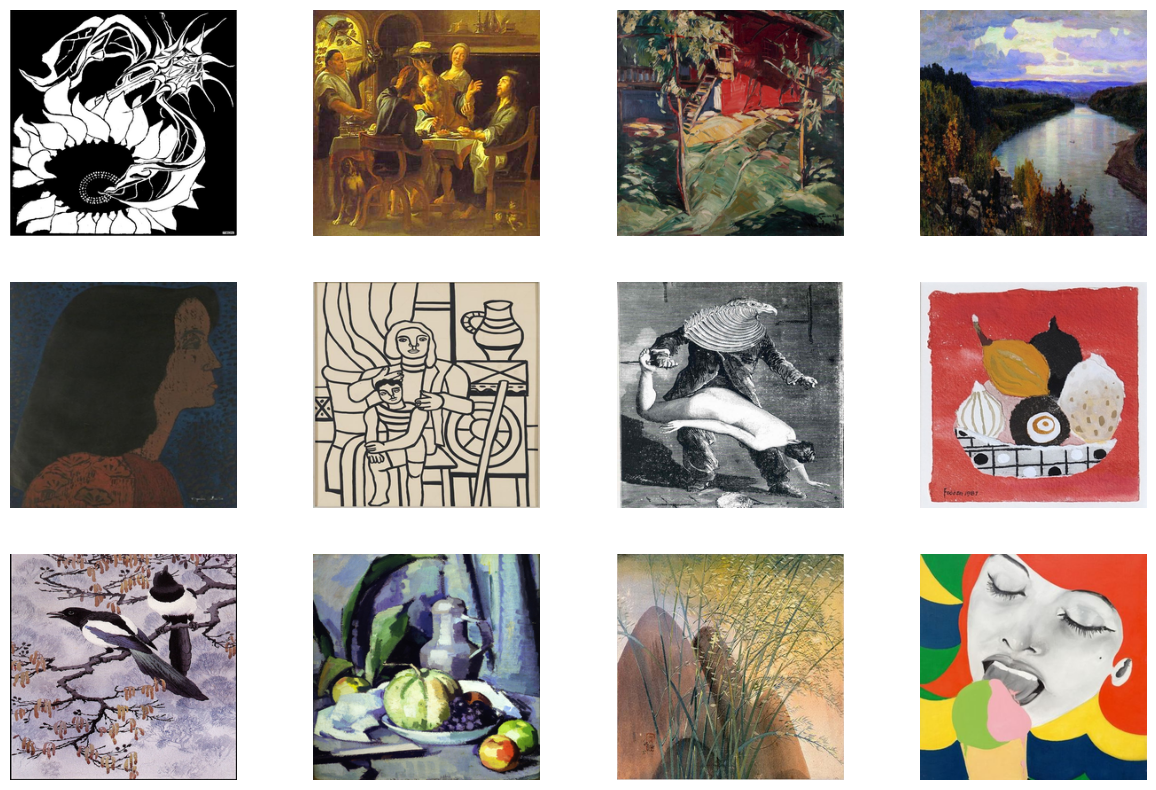

[DISPLAY] Images de la catégorie : Photo


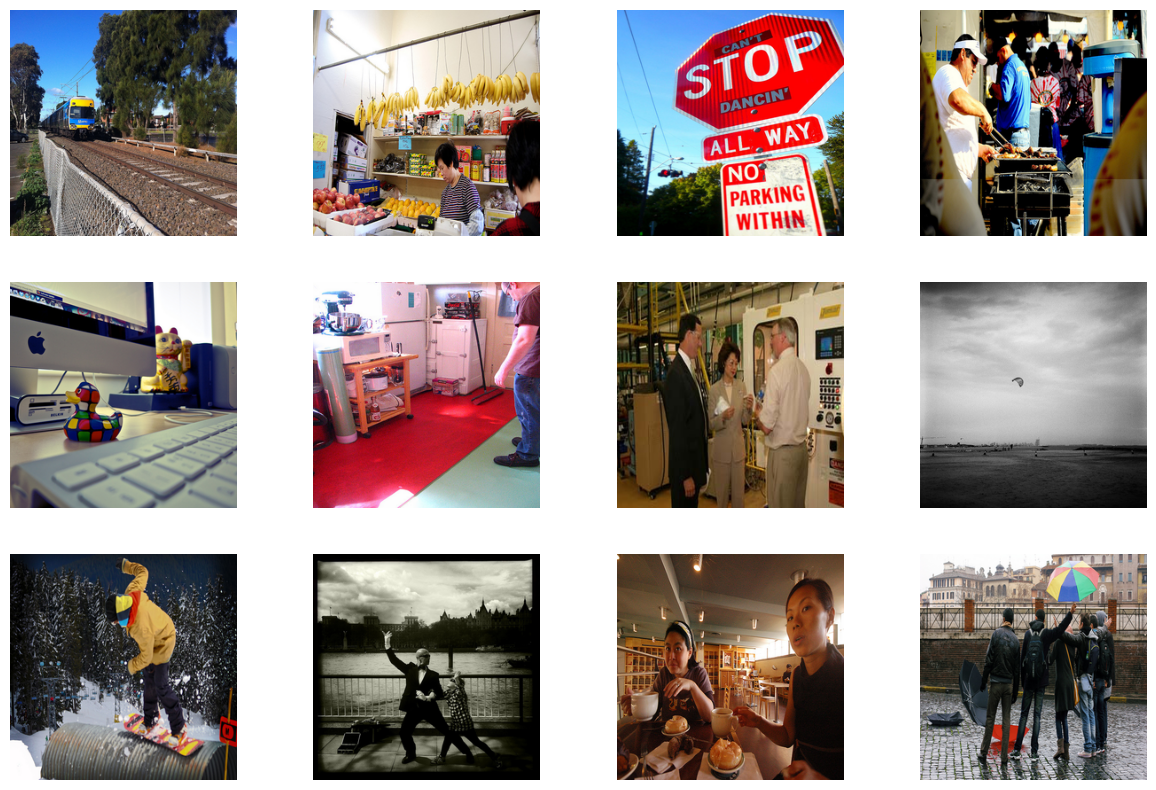

[DISPLAY] Images de la catégorie : Schematics


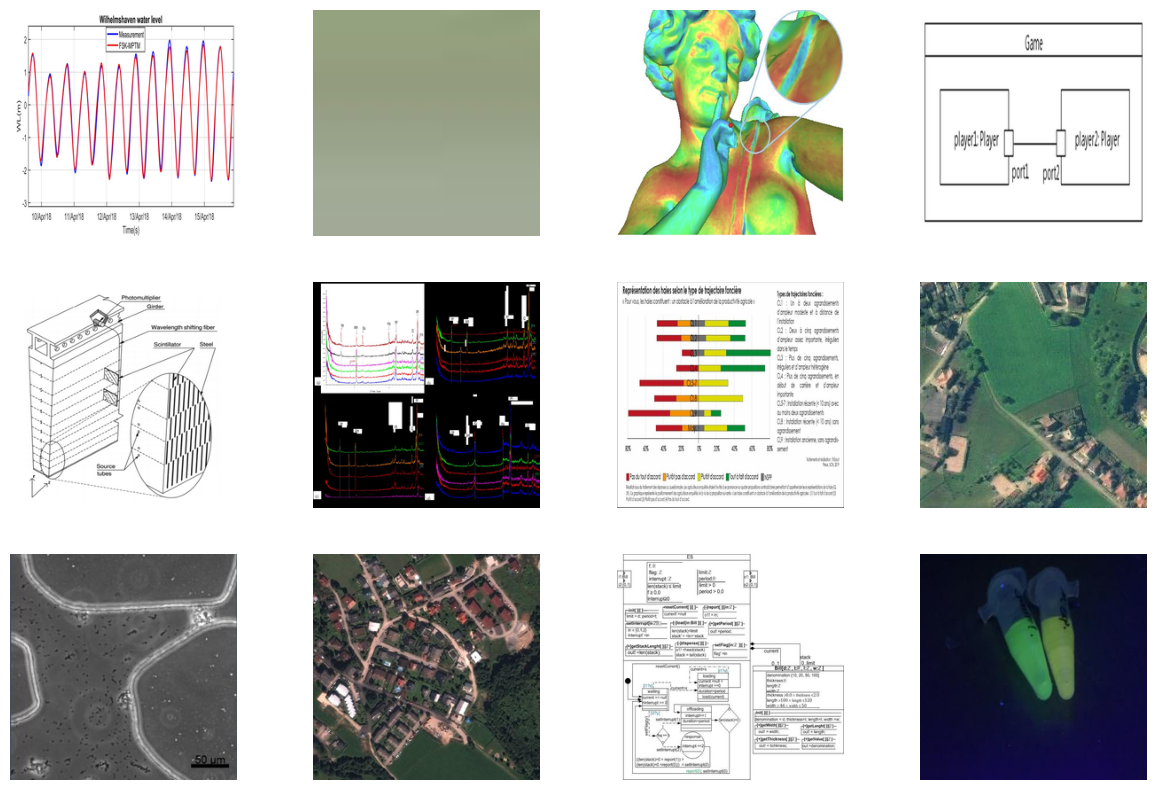

[DISPLAY] Images de la catégorie : Sketch


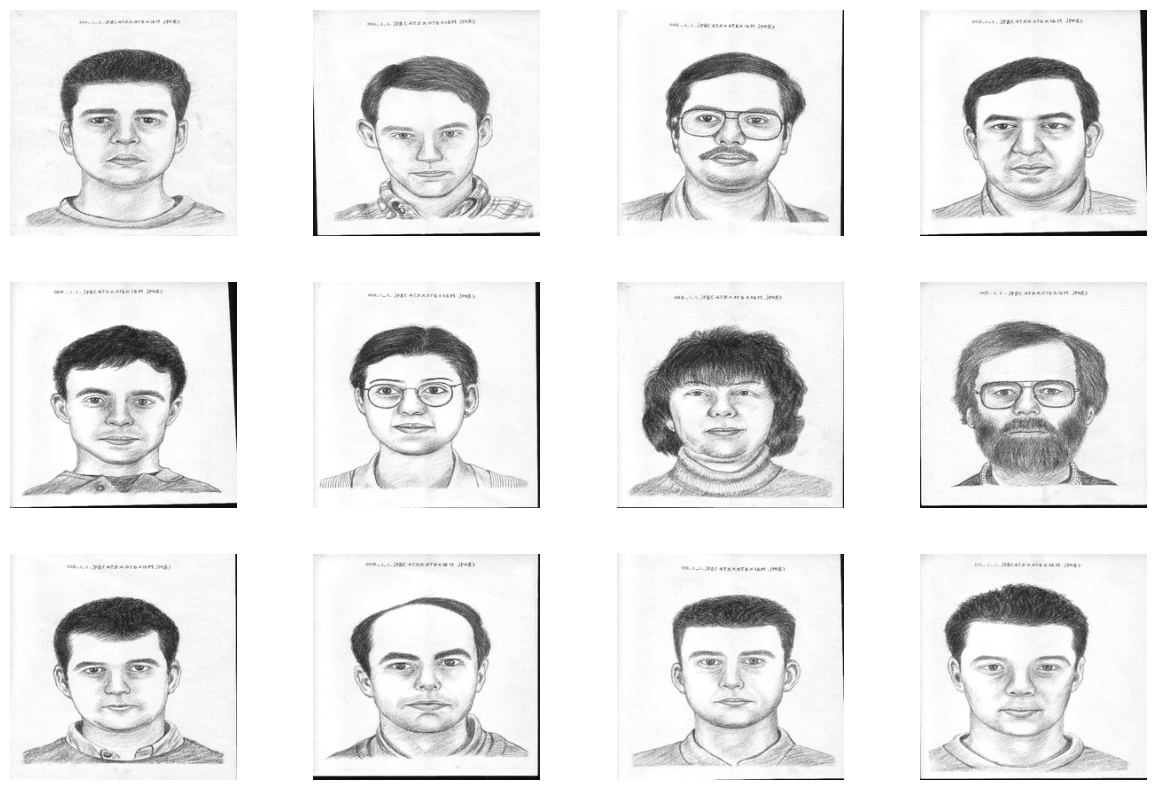

[DISPLAY] Images de la catégorie : Text


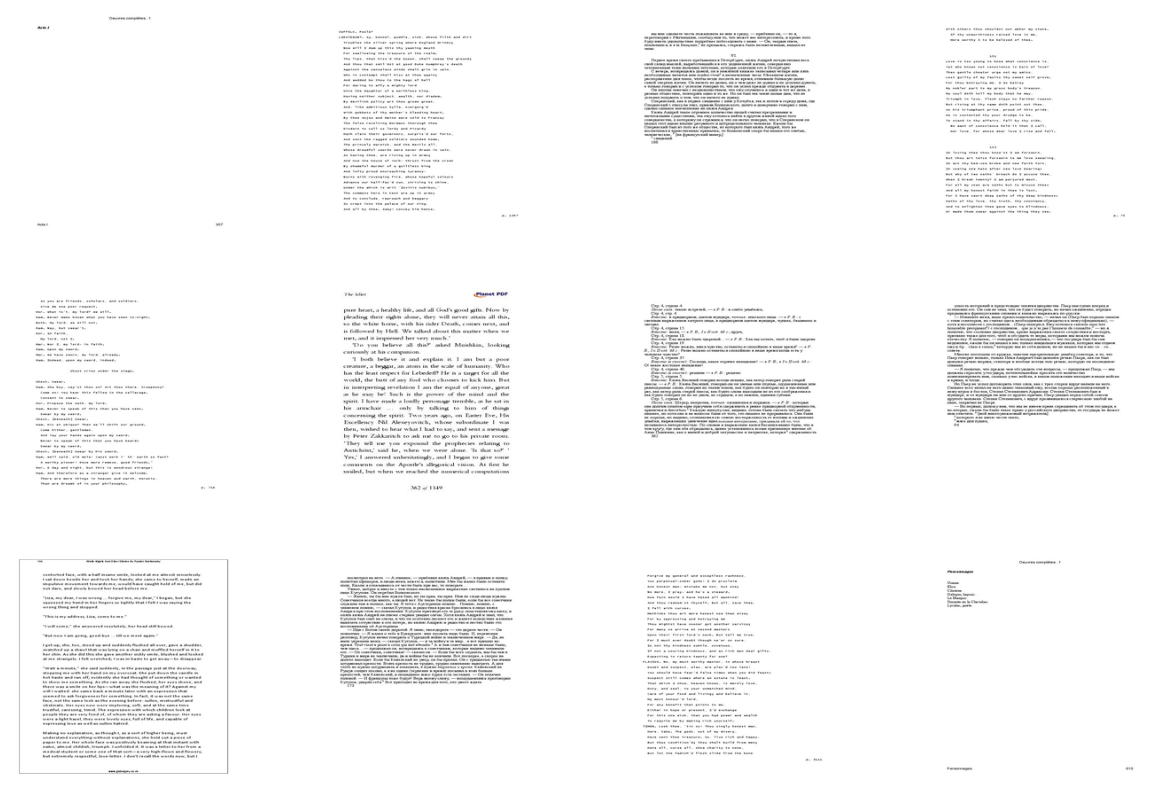

In [4]:
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# =======================
# Fusion : Conversion en RGB + Redimensionnement à 256x256
# =======================

categories = ["Painting", "Photo", "Schematics", "Sketch", "Text"]
max_files = 5000  # Limite de traitement par catégorie

for category in categories:
    path = os.path.join(working_dir, category)

    # On récupère les fichiers image (max 5000)
    files = [f for f in os.listdir(path)
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))
             and os.path.isfile(os.path.join(path, f))]
    files = files[:max_files]  # Appliquer la limite

    for file_name in tqdm(files, desc=f"[PROCESS & RESIZE] {category}", unit="image"):
        file_path = os.path.join(path, file_name)
        base_name, ext = os.path.splitext(file_name)

        try:
            # Conversion RGB + redimensionnement
            img = Image.open(file_path).convert("RGB")
            img_resized = img.resize((256, 256), Image.Resampling.LANCZOS)

            new_filename = base_name + ".png"
            dest_path = os.path.join(path, new_filename)
            img_resized.save(dest_path, "PNG")

            # Suppression du fichier original si nécessaire
            if os.path.abspath(dest_path) != os.path.abspath(file_path):
                os.remove(file_path)

        except Exception as e:
            print(f"[ERROR] Fichier {file_path} : {e}")

print("[INFO] Conversion et redimensionnement des images terminés.")

# =======================
# Affichage de 12 images par catégorie
# =======================
def display_images_from_folder(folder_path):
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    images = images[:12]  # Limite à 12 images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

for category in categories:
    path = os.path.join(working_dir, category)
    print(f"[DISPLAY] Images de la catégorie : {category}")
    display_images_from_folder(path)


In [1]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# 📸 Binary Image Classification: Photo vs Non-Photo

Ce pipeline vise à entraîner un modèle de classification binaire à partir d’un ensemble d’images réparties dans les 5 catégories suivantes :
- Painting
- Photo
- Schematics
- Sketch
- Text

L’objectif est de détecter si une image appartient à la catégorie **"Photo"** ou non (**"Non-Photo"**).  
Les images ont toutes été converties au format `.png`, en RGB, redimensionnées à **256x256**, et placées dans les dossiers correspondants.

---


In [2]:
# Replace with your actual working directory
working_dir = "./images_work"
binary_dataset_dir = os.path.join(working_dir, "binary_data")
photo_dir = os.path.join(binary_dataset_dir, "photo")
non_photo_dir = os.path.join(binary_dataset_dir, "non_photo")

os.makedirs(photo_dir, exist_ok=True)
os.makedirs(non_photo_dir, exist_ok=True)

categories = ["Painting", "Photo", "Schematics", "Sketch", "Text"]

# Populate binary dataset folders
for category in categories:
    source_dir = os.path.join(working_dir, category)
    target_dir = photo_dir if category == "Photo" else non_photo_dir

    for file_name in os.listdir(source_dir)[:5000]:
        file_path = os.path.join(source_dir, file_name)
        target_path = os.path.join(target_dir, f"{category}_{file_name}")
        if os.path.isfile(file_path):
            tf.io.gfile.copy(file_path, target_path, overwrite=True)


## 🧪 Data preparation

Nous utilisons `ImageDataGenerator` pour :
- redimensionner les images à `256x256`
- effectuer une normalisation [0, 1]
- générer un ensemble d'entraînement et de validation (split 80/20)
- appliquer un léger data augmentation

---


In [3]:
img_size = 256
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    binary_dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

val_generator = datagen.flow_from_directory(
    binary_dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)


Found 17124 images belonging to 2 classes.
Found 4281 images belonging to 2 classes.


## 🧠 Conception du modèle CNN

Nous définissons ici un modèle de réseau de neurones convolutif (CNN) adapté à la classification binaire.  
Il inclut :

- 🧱 3 blocs convolutionnels avec `BatchNormalization` et `MaxPooling`
- 🧹 Dropout pour éviter le surapprentissage
- 🧲 L2 regularization (ridge) pour améliorer la généralisation
- 🧮 Activation finale `sigmoid` pour produire une probabilité

Nous utiliserons :
- La fonction de perte `binary_crossentropy`
- L’optimiseur `Adam`
- La métrique `accuracy`

---


In [4]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

## ▶️ Étapes suivantes

Le modèle est maintenant prêt à être entraîné !  
Nous allons maintenant :

- Ajouter des callbacks pour surveiller l’entraînement
  - 🔁 EarlyStopping
  - 💾 ModelCheckpoint
- Visualiser les performances via les courbes `accuracy` et `loss`
- Lancer l'entraînement du modèle

👉 Passons à l'étape suivante : **entraînement du modèle et visualisation des résultats**


## ⚙️ Entraînement du modèle

Nous allons entraîner le modèle avec :

- **EarlyStopping** : arrête l'entraînement si la validation stagne
- **ModelCheckpoint** : sauvegarde le meilleur modèle
- Entraînement sur 20 époques max

Nous visualiserons ensuite :
- 📈 La courbe de perte (loss)
- 📊 La courbe de précision (accuracy)

---


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Dossier pour sauvegarder le meilleur modèle
checkpoint_path = "best_model.keras"

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
]


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
421/536 [======================>.......] - ETA: 5:03 - loss: 1.8415 - accuracy: 0.8020

## 📊 Visualisation des courbes d'entraînement

Les courbes suivantes permettent de détecter :
- du **sur-apprentissage** (overfitting)
- un modèle mal entraîné (val_loss qui stagne)
- la stabilité de l’apprentissage

---


In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.show()

plot_training_curves(history)

